In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [12]:
dataset = NWBDataset('/home/dmifsud/Projects/NDT-U/data/mc_rtt_train.nwb', split_heldout=False)

In [4]:
dataset.data

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
clock_time                                                                      
0 days 00:00:00         -4.368126  56.778511  -4.357695  56.758063  94.737781   
0 days 00:00:00.001000  -4.367445  56.776709  -4.356471  56.755696  94.736662   
0 days 00:00:00.002000  -4.366716  56.774849  -4.355222  56.753297  94.735519   
0 days 00:00:00.003000  -4.365940  56.772930  -4.353950  56.750865  94.734355   
0 days 00:00:00.004000  -4.365118  56.770954  -4.352654  56.748402  94.733168   
...                           ...        ...        ...        ...        ...   
0 days 00:10:49.095000  21.912910  21.772385  21.910600  21.775553  87.763974   
0 days 00:10:49.096000  21.912572  21.772658  21.910276  21.775811  87.764095   
0 days 00:10:49.097000  21.912233  21.772935  21.909954  21.776069  87.764220   
0 days 00:10:49.098000  21.911894  21.773216  21.909634  21.776326  87.764350   
0 days 00:10:49.099000  21.911554  21.773500  21.909317  21.776582  87.764485   

signal_type            finger_vel           heldout_spikes            ...  \
channel                         x         y            201  203  204  ...   
clock_time                                                            ...   
0 days 00:00:00          1.211079 -2.349968            0.0  0.0  0.0  ...   
0 days 00:00:00.001000   1.236134 -2.383193            0.0  0.0  0.0  ...   
0 days 00:00:00.002000   1.260579 -2.415633            0.0  0.0  0.0  ...   
0 days 00:00:00.003000   1.284410 -2.447283            0.0  0.0  0.0  ...   
0 days 00:00:00.004000   1.307626 -2.478143            0.0  0.0  0.0  ...   
...                           ...       ...            ...  ...  ...  ...   
0 days 00:10:49.095000  -0.325126  0.258578            0.0  0.0  0.0  ...   
0 days 00:10:49.096000  -0.323063  0.258088            0.0  0.0  0.0  ...   
0 days 00:10:49.097000  -0.320876  0.257396            0.0  0.0  0.0  ...   
0 days 00:10:49.098000  -0.318591  0.256517            0.0  0.0  0.0  ...   
0 days 00:10:49.099000  -0.316212  0.255452            0.0  0.0  0.0  ...   

signal_type            spikes                                    target_pos  \
channel                  8901 9103 9201 9203 9403 9501 9502 9601          x   
clock_time                                                                    
0 days 00:00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   
0 days 00:00:00.001000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   
0 days 00:00:00.002000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   
0 days 00:00:00.003000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   
0 days 00:00:00.004000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       -7.5   
...                       ...  ...  ...  ...  ...  ...  ...  ...        ...   
0 days 00:10:49.095000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       37.5   
0 days 00:10:49.096000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       37.5   
0 days 00:10:49.097000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       37.5   
0 days 00:10:49.098000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       37.5   
0 days 00:10:49.099000    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       37.5   

signal_type                   
channel                    y  
clock_time                    
0 days 00:00:00         52.5  
0 days 00:00:00.001000  52.5  
0 days 00:00:00.002000  52.5  
0 days 00:00:00.003000  52.5  
0 days 00:00:00.004000  52.5  
...                      ...  
0 days 00:10:49.095000  82.5  
0 days 00:10:49.096000  82.5  
0 days 00:10:49.097000  82.5  
0 days 00:10:49.098000  82.5  
0 days 00:10:49.099000  82.5  

[649100 rows x 139 columns]

In [13]:
## Make trial data

# Find when target pos changes
has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
# Find if target pos change corresponds to NaN-padded gap between files
change_nan = dataset.data[has_change].isna().any(axis=1)
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
drop_trial = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True))[:-1]
# Add start and end times to trial info
change_times = dataset.data.index[has_change]
start_times = change_times[:-1][~drop_trial]
end_times = change_times[1:][~drop_trial]
# Get target position per trial
target_pos = dataset.data.target_pos.loc[start_times].to_numpy().tolist()
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

In [209]:
dataset.trial_info[dataset.trial_info.trial_id == 11].reach_angle

11   -90.0
Name: reach_angle, dtype: float64

In [198]:
dataset.trial_info

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
0,0,0 days 00:00:01.352000,0 days 00:00:02.712000,"[-37.5, 82.5]",-90.0,15.0,170.537678
1,1,0 days 00:00:02.712000,0 days 00:00:03.952000,"[22.5, 67.5]",60.0,-15.0,-14.036243
2,2,0 days 00:00:03.952000,0 days 00:00:05.112000,"[-22.5, 7.5]",-45.0,-60.0,-126.869898
3,3,0 days 00:00:05.112000,0 days 00:00:06.364000,"[-52.5, 67.5]",-30.0,60.0,116.565051
4,4,0 days 00:00:06.364000,0 days 00:00:07.672000,"[-37.5, 52.5]",15.0,-15.0,-45.000000
...,...,...,...,...,...,...,...
535,535,0 days 00:10:41.644000,0 days 00:10:42.864000,"[-52.5, 82.5]",-105.0,0.0,180.000000
536,536,0 days 00:10:42.864000,0 days 00:10:43.732000,"[-22.5, 67.5]",30.0,-15.0,-26.565051
537,537,0 days 00:10:43.732000,0 days 00:10:46.496000,"[-7.5, 7.5]",15.0,-60.0,-75.963757
538,538,0 days 00:10:46.496000,0 days 00:10:47.924000,"[-52.5, 37.5]",-45.0,30.0,146.309932


In [14]:
dataset.resample(10)

In [168]:
axis_labels = f"yaxis: {{title: {{text: 'ch 1',}}, showticklabels: false, fixedrange: true}},\n"
for i in range(2,99):
    axis_labels += f"yaxis{i}: {{title: {{text: 'ch {i}',}}, showticklabels: false, fixedrange: true}},\n"

In [169]:
with open(f"test.txt", "w") as f:
    f.write(axis_labels)

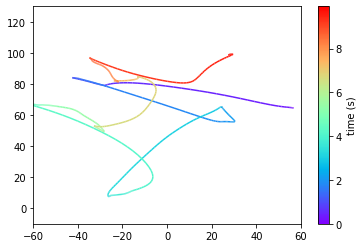

In [27]:
## Plot a few reaches

# Extract start and end times, target positions
start = dataset.trial_info.iloc[0].start_time # arbitrarily using 1st through 6th reaches
end = dataset.trial_info.iloc[7].end_time - pd.Timedelta(1, 'ms')
targets = dataset.trial_info.target_pos.iloc[0:8].to_numpy().tolist()
tts = dataset.trial_info.end_time.iloc[0:8] - start

# Get cursor position data
reach_data = dataset.data.cursor_pos.loc[start:end].to_numpy().reshape(-1, 1, 2)
reach_seg = np.concatenate([reach_data[:-1], reach_data[1:]], axis=1)
# Split into collection of lines for color gradient
lc = LineCollection(reach_seg, cmap='rainbow', norm=plt.Normalize(0, len(reach_seg) * dataset.bin_width / 1000))
lc.set_array(np.arange(len(reach_seg)) * dataset.bin_width / 1000)

# Plot lines and add targets
ax = plt.axes()
lines = ax.add_collection(lc)
# for tt, target in zip(tts, targets):
#     ax.plot(target[0], target[1], marker='o', markersize=8, color=plt.get_cmap('rainbow')(tt.total_seconds() * 1000 / dataset.bin_width / len(reach_seg)))
ax.set_xlim(-60, 60)
ax.set_ylim(-10, 130)
plt.colorbar(lines, label='time (s)')
plt.show()

In [16]:
## Compute speed onset for each reach, for plotting alignment

# Calculate speed and call `calculate_onset`
speed = np.linalg.norm(dataset.data.finger_vel, axis=1)
dataset.data['speed'] = speed
peak_times = dataset.calculate_onset('speed', 0.05)

In [202]:
dataset.trial_info.speed_onset.isnull().sum()

374

In [203]:
540-376

164

In [17]:
## Prep data

# Smooth spikes with 50 ms std Gaussian
dataset.smooth_spk(50, name='smth_50', ignore_nans=True)

# Lag velocity by 120 ms relative to neural data
lag = 120
lag_bins = int(round(lag / dataset.bin_width))
nans = dataset.data.finger_vel.x.isna().reset_index(drop=True)
rates = dataset.data.spikes_smth_50[~nans.to_numpy() & ~nans.shift(-lag_bins, fill_value=True).to_numpy()].to_numpy()
vel = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].to_numpy()
vel_index = dataset.data.finger_vel[~nans.to_numpy() & ~nans.shift(lag_bins, fill_value=True).to_numpy()].index

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(rates)
test2 = pca.transform(rates)

In [19]:
## Kinematic decoding

# Fit decoder and evaluate
gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 9)})
gscv.fit(rates, vel)
print(f'Decoding R2: {gscv.best_score_}')
pred_vel = gscv.predict(rates)

# Add data back to main dataframe
pred_vel_df = pd.DataFrame(pred_vel, index=vel_index, columns=pd.MultiIndex.from_tuples([('pred_vel', 'x'), ('pred_vel', 'y')]))
dataset.data = pd.concat([dataset.data, pred_vel_df], axis=1)
# Add data back to main dataframe
pred_vel_df = pd.DataFrame(test2, index=vel_index, columns=pd.MultiIndex.from_tuples([('pca', 'x'), ('pca', 'y'),('pca', 'z'),]))
dataset.data = pd.concat([dataset.data, pred_vel_df], axis=1)

Decoding R2: 0.46388753355995893


In [20]:
pred_vel.shape

(64838, 2)

In [22]:
rates.shape

(64838, 130)

In [21]:
vel.shape

(64838, 2)

In [89]:
test2.shape

(64838, 3)

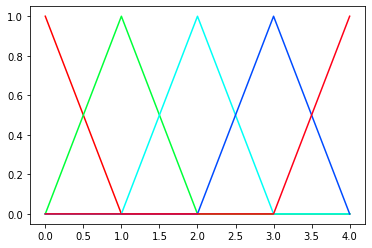

In [172]:
from turtle import color
from matplotlib import cm, colors

norm = colors.Normalize(vmin=-360.0, vmax=360.0, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='hsv')

plt.plot([1,0,0,0,0], color=mapper.to_rgba(-360))
plt.plot([0,1,0,0,0], color=mapper.to_rgba(-90))
plt.plot([0,0,1,0,0], color=mapper.to_rgba(0))
plt.plot([0,0,0,1,0], color=mapper.to_rgba(90))
plt.plot([0,0,0,0,1], color=mapper.to_rgba(360))

In [226]:
min(min([9,4,5]), min([9,8]), min([1,2]))

1

In [7]:
-1-(9*0.05)

-1.45

In [8]:
10+(9*0.05)

10.45

In [89]:
import os
import sys
import h5py
import torch
import numpy as np
import scipy.signal as signal
import plotly.graph_objects as go
from datasets import get_dataloaders
from setup import set_device, set_seeds
from configs.default_config import get_config_from_file
from nlb_tools.make_tensors import h5_to_dict
from nlb_tools.nwb_interface import NWBDataset
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from turtle import color
from matplotlib import cm, colors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
import plotly.graph_objects as go
import numpy as np

In [90]:
norm = colors.Normalize(vmin=-180, vmax=180, clip=True)
hsv_cmap = cm.get_cmap('hsv')
mapper = cm.ScalarMappable(norm=norm, cmap='hsv')
mapper.set_array([])

In [107]:
colors.to_hex(mapper.to_cm())

AttributeError: 'ScalarMappable' object has no attribute 'to_cm'

In [91]:
mapper.to_rgba(180.0)

(1.0, 0.0, 0.09375, 1.0)

In [105]:
mapper.to_hex(180)

AttributeError: 'ScalarMappable' object has no attribute 'to_hex'

In [186]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

rs = np.random.RandomState()
rs.seed(0)

def brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20):
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = rs.standard_normal(size = N)
    W = np.cumsum(W)*np.sqrt(dt) # standard brownian motion
    X = (mu-0.5*sigma**2)*t + sigma*W
    S = S0*np.exp(X) # geometric brownian motion
    return S

dates = pd.date_range('2012-01-01', '2013-02-22')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
y = brownian_motion(T, N, sigma=0.1, S0=start_price)
z = brownian_motion(T, N, sigma=0.1, S0=start_price)

fig = go.Figure(data=go.Scatter3d(
    x=dates, y=y, z=z,
    mode='lines',
    # marker=dict(
    #     size=0,
    #     color=z,
    #     colorscale='Viridis',
    # ),
    line=dict(
        color=f'{colors.rgb2hex(mapper.to_rgba(90.0))}',
        width=2
    )
))

fig.update_layout(
    width=1000,
    height=700,
    autosize=False,
    title="PCA of NDT Rates",
    scene=dict(
        xaxis_showspikes=False,
        yaxis_showspikes=False,
        zaxis_showspikes=False,
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=1.23,
                y=1.23,
                z=1.23,
            ),
            center=dict(
                x=0.0,
                y=0.0,
                z=0.0,
            ),
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'manual'
    ),
)
fig.update_layout(margin=dict(r=90, l=0, b=10, t=60))
fig.add_layout_image(
    dict(
        source="https://domenick-m.github.io/NDT-Timing-Test/plots/color_wheel.png",
        xref="paper", yref="paper",
        x=1.09, y=0.01,
        sizex=0.35, sizey=0.35,
        xanchor="right", yanchor="bottom"
    )
)
fig.show()

In [83]:
print(f'╔═══════════════════════════╗\n║ NDT Rates Decoding:       ║\n║   {0.034565:.3f} R\u00b2                ║\n╚═══════════════════════════╝')


╔═══════════════════════════╗
║ NDT Rates Decoding:       ║
║   0.035 R²                ║
╚═══════════════════════════╝


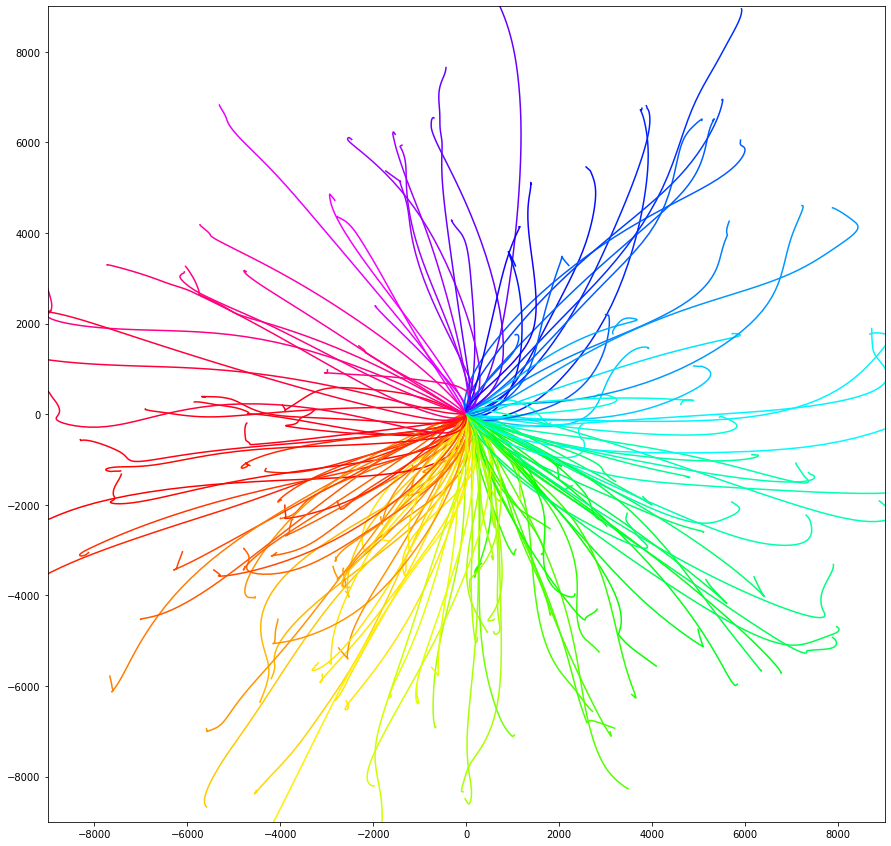

In [25]:
from turtle import color
from matplotlib import cm, colors


max_angle = -1000
min_angle = 1000
for tid, trial in trial_data.groupby('trial_id'):
    angle = dataset.trial_info[dataset.trial_info.trial_id == tid].reach_angle
    if angle.item() < min_angle:
        min_angle = angle.item()
    if angle.item() > max_angle:
        max_angle = angle.item()

norm = colors.Normalize(vmin=min_angle, vmax=max_angle, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='hsv')

fig = plt.figure(figsize=(15,15))
# ax = plt.axes(projection='3d')
plt.xlim([-9000,9000])
plt.ylim([-9000,9000])
# plt.xlim([-500,500])
# plt.ylim([-500,500])
plt.legend()

for tid, trial in trial_data.groupby('trial_id'):
    angle = dataset.trial_info[dataset.trial_info.trial_id == tid].reach_angle
    # plt.plot(trial.finger_vel.x, trial.finger_vel.y, color=mapper.to_rgba(angle), alpha=0.5)
    # ax.plot3D(trial.pca.z, trial.pca.y, trial.pca.x, color=mapper.to_rgba(angle), alpha=0.5)
    plt.plot(np.cumsum(trial.finger_vel.x), np.cumsum(trial.finger_vel.y), color=mapper.to_rgba(angle))
    # plt.plot(np.cumsum(trial.finger_vel.x[29:]), np.cumsum(trial.finger_vel.y[29:]), color=mapper.to_rgba(angle))
        # plt.plot(trial.cursor_pos.x*50, trial.cursor_pos.y*50, color='blue')

In [162]:
max_angle

180.0

In [163]:
min_angle

-170.53767779197437

ValueError: x and y must have same first dimension, but have shapes (105,) and (75,)

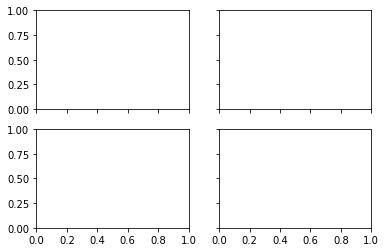

In [24]:
## Plot predicted vs true kinematics

# Coloring function
get_color = lambda idx, series: plt.get_cmap('Greens')((series[idx] - series.min()) / (series.max() - series.min()))
# Extract trial data aligned to movement onset
trial_data = dataset.make_trial_data(align_field='speed_onset', align_range=(0, 750), allow_nans=True)

# Initialize figure
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
# Loop through trials and plot on appropriate subplots
for tid, trial in trial_data.groupby('trial_id'):
    axs[0][0].plot(np.arange(-300, 750, dataset.bin_width), trial.finger_vel.x, color=get_color(tid, dataset.trial_info.reach_dist_x))
    axs[0][1].plot(np.arange(-300, 750, dataset.bin_width), trial.finger_vel.y, color=get_color(tid, dataset.trial_info.reach_dist_y))
    axs[1][0].plot(np.arange(-300, 750, dataset.bin_width), trial.pred_vel.x, color=get_color(tid, dataset.trial_info.reach_dist_x))
    axs[1][1].plot(np.arange(-300, 750, dataset.bin_width), trial.pred_vel.y, color=get_color(tid, dataset.trial_info.reach_dist_y))

# Add labels
axs[0][0].set_title('X velocity')
axs[0][1].set_title('Y velocity')
axs[0][0].set_ylabel('True velocity')
axs[1][0].set_ylabel('Predicted velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after move onset (ms)')
axs[0][0].set_xlim(-300, 750)
plt.show()

In [56]:
trial_data.trial_id

0         11
1         11
2         11
3         11
4         11
        ... 
12445    536
12446    536
12447    536
12448    536
12449    536
Name: trial_id, Length: 12450, dtype: int64

In [59]:
trial_data[trial_data.trial_id == 536]

align_time             clock_time cursor_pos             \
                                                             x          y   
12375        0 days 00:00:00 0 days 00:10:43.060000 -55.344416  81.728261   
12376 0 days 00:00:00.010000 0 days 00:10:43.070000 -55.333628  81.703673   
12377 0 days 00:00:00.020000 0 days 00:10:43.080000 -55.289381  81.654439   
12378 0 days 00:00:00.030000 0 days 00:10:43.090000 -55.182463  81.566332   
12379 0 days 00:00:00.040000 0 days 00:10:43.100000 -54.975719  81.425030   
...                      ...                    ...        ...        ...   
12445 0 days 00:00:00.700000 0 days 00:10:43.760000 -23.210367  66.853473   
12446 0 days 00:00:00.710000 0 days 00:10:43.770000 -23.202352  66.850698   
12447 0 days 00:00:00.720000 0 days 00:10:43.780000 -23.195106  66.848230   
12448 0 days 00:00:00.730000 0 days 00:10:43.790000 -23.188764  66.846155   
12449 0 days 00:00:00.740000 0 days 00:10:43.800000 -23.183508  66.844596   

      finger_pos                       finger_vel            margin  ...  \
               x          y          z          x          y         ...   
12375 -55.301970  81.680040  86.972519   5.981005  -5.672373  False  ...   
12376 -55.211606  81.604772  86.990537  12.596731  -9.587281  False  ...   
12377 -55.039714  81.484685  87.017119  22.327656 -14.588212  False  ...   
12378 -54.754515  81.310601  87.052460  35.238318 -20.316396  False  ...   
12379 -54.325558  81.077429  87.095334  50.971612 -26.322757  False  ...   
...          ...        ...        ...        ...        ...    ...  ...   
12445 -23.213460  66.856753  88.072330   0.991060  -0.414092  False  ...   
12446 -23.204391  66.853060  88.072183   0.821751  -0.324442  False  ...   
12447 -23.196968  66.850238  88.072166   0.669731  -0.242874  False  ...   
12448 -23.190813  66.848120  88.072143   0.572072  -0.185672  False  ...   
12449 -23.185321  66.846428  88.072133   0.536022  -0.157495  False  ...   

      spikes_smth_50                                    target_pos        \
                9301      9403      9501 9502 9601 9602          x     y   
12375       0.062617  0.147081  0.070601  0.0  0.0  0.0      -22.5  67.5   
12376       0.070601  0.147081  0.077674  0.0  0.0  0.0      -22.5  67.5   
12377       0.076481  0.142219  0.081692  0.0  0.0  0.0      -22.5  67.5   
12378       0.079602  0.132961  0.083117  0.0  0.0  0.0      -22.5  67.5   
12379       0.079602  0.120167  0.082161  0.0  0.0  0.0      -22.5  67.5   
...              ...       ...       ...  ...  ...  ...        ...   ...   
12445       0.000000  0.005680  0.006874  0.0  0.0  0.0       -7.5   7.5   
12446       0.000000  0.008820  0.005605  0.0  0.0  0.0       -7.5   7.5   
12447       0.000000  0.013158  0.005605  0.0  0.0  0.0       -7.5   7.5   
12448       0.000000  0.018860  0.006874  0.0  0.0  0.0       -7.5   7.5   
12449       0.000000  0.025972  0.010014  0.0  0.0  0.0       -7.5   7.5   

      trial_id             trial_time  
                                       
12375      536 0 days 00:00:00.190000  
12376      536 0 days 00:00:00.200000  
12377      536 0 days 00:00:00.210000  
12378      536 0 days 00:00:00.220000  
12379      536 0 days 00:00:00.230000  
...        ...                    ...  
12445      536 0 days 00:00:00.890000  
12446      536 0 days 00:00:00.900000  
12447      536 0 days 00:00:00.910000  
12448      536 0 days 00:00:00.920000  
12449      536 0 days 00:00:00.930000  

[75 rows x 277 columns]